In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
import pickle
import os
from matplotlib import rcParams
from matplotlib.patches import Patch
from dynamicTreeCut import cutreeHybrid

# --- Setup Matplotlib for consistent font rendering ---
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'


In [3]:
# ==========================================
# 1. Load the Model
# ==========================================
model_path = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/daporinad_new_splits/DAPORINAD_NAMPT_forgeModel_rankedHP_321456.pkl"

print(f"Loading model from: {model_path}")
with open(model_path, "rb") as f:
    model = pickle.load(f)

Loading model from: /home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/daporinad_new_splits/DAPORINAD_NAMPT_forgeModel_rankedHP_321456.pkl


In [4]:
exp_data = pd.read_csv(model.exp_path, header = 0, index_col = 0)
dep_data = pd.read_csv(model.dep_path, header = 0, index_col = 0)
ic50_data = pd.read_csv(model.ic50_path, header = 0, index_col = 0)
ic50_data = model.ic50_data.T
exp_data.shape, dep_data.shape, ic50_data.shape

((1076, 16289), (1076, 17916), (1325, 187))

In [5]:
# B. Find Common Cell Lines
common_cellLines = list(set(exp_data.index) & set(dep_data.index) & set(ic50_data.index))
print(f"Common cell lines found: {len(common_cellLines)}")

Common cell lines found: 700


In [6]:
exp_data_subset = exp_data.loc[common_cellLines, model.hcg_list].drop_duplicates(keep='first')
dep_target = dep_data.loc[common_cellLines, model.target].dropna().drop_duplicates(keep='first')
drug_ic50 = ic50_data.loc[common_cellLines, model.drug].dropna().drop_duplicates(keep='first')
exp_data_subset = exp_data.loc[dep_target.index, model.hcg_list]
drug_ic50 = ic50_data.loc[dep_target.index, model.drug]
exp_data_subset.shape, dep_target.shape, drug_ic50.shape

((697, 199), (697,), (697,))

In [7]:
model.exp_data = exp_data_subset
model.dep_data = dep_target
model.ic50_data = drug_ic50
model.exp_data.shape, model.dep_data.shape, model.ic50_data.shape

((697, 199), (697,), (697,))

In [8]:
common_train_cellLines = list(set(model.train_cellLines) & set(model.exp_data.index))
common_test_cellLines = list(set(model.test_cellLines) & set(model.exp_data.index))

In [9]:
len(common_train_cellLines), len(common_test_cellLines)

(517, 130)

In [10]:
# ==========================================
# 3. Train/Test Split & Latent Factor Calculation
# ==========================================

# Prepare Matrices
G_train = model.exp_data.loc[common_train_cellLines, :].to_numpy()
G_test  = model.exp_data.loc[common_test_cellLines, :].to_numpy()

# Calculate Latent Embeddings (Z = Expression @ Weights)
Z_train = G_train @ model.W
Z_test  = G_test  @ model.W

# Calculate Predictions (Simulated as per your request logic)
# Note: Using model.hD and model.hI
pred_dep_train = Z_train @ model.hD
pred_ic50_train = Z_train @ model.hI
pred_dep_test  = Z_test  @ model.hD
pred_ic50_test = Z_test  @ model.hI

In [13]:
G_train.shape

(517, 199)

In [ ]:
# ==========================================
# 4. Construct Plotting DataFrame
# ==========================================

# Training DataFrame
Z_train_df = pd.DataFrame(Z_train, index=common_train_cellLines, columns=[i + 1 for i in range(Z_train.shape[1])])
Z_train_df["actual_dep_NAMPT"] = dep_target.loc[common_train_cellLines].values
Z_train_df["actual_IC50"] = drug_ic50.loc[common_train_cellLines].values
Z_train_df["pred_dep_NAMPT"] = pred_dep_train
Z_train_df["pred_IC50"] = pred_ic50_train
Z_train_df["Set"] = "Train"

# Testing DataFrame
Z_test_df = pd.DataFrame(Z_test, index=common_test_cellLines, columns=[i + 1 for i in range(Z_test.shape[1])])
Z_test_df["actual_dep_NAMPT"] = dep_target.loc[common_test_cellLines].values
Z_test_df["actual_IC50"] = drug_ic50.loc[common_test_cellLines].values
Z_test_df["pred_dep_NAMPT"] = pred_dep_test
Z_test_df["pred_IC50"] = pred_ic50_test
Z_test_df["Set"] = "Test"

# Combine
Z_combined_df = pd.concat([Z_train_df, Z_test_df])

# Calculate Benefit Score (Predicted Dependency - Predicted IC50)
Z_combined_df["Benefit_Score"] = Z_combined_df["pred_dep_NAMPT"] - Z_combined_df["pred_IC50"]
Z_combined_df.index.name = "Cell_line"

# The final dataframe for clustering (only latent factors)
Z_plot_df = Z_combined_df.iloc[:, :Z_train.shape[1]]

print("Z_combined_df DataFrame successfully created.")
print(f"Total cell lines to plot: {len(Z_combined_df)}")

Z_combined_df DataFrame successfully created.
Total cell lines to plot: 647


In [ ]:
# ==========================================
# 5. Hierarchical Clustering
# ==========================================
print("Performing hierarchical clustering...")

# Linkage
row_dist = pdist(Z_plot_df.values, metric='euclidean')
row_link = linkage(row_dist, method='ward')
col_link = linkage(pdist(Z_plot_df.T.values), method='ward')

# Dynamic Tree Cut
# Note: Adjust deepSplit or minClusterSize if you get too few/many clusters
cluster_result = cutreeHybrid(row_link, row_dist, deepSplit=4, minClusterSize=13)
cluster_labels = pd.Series(cluster_result["labels"], index=Z_plot_df.index, name="Cluster")
num_clusters = len(np.unique(cluster_labels[cluster_labels != 0]))
print(f"Dynamic Tree Cut found {num_clusters} clusters.")

# Prepare Row Colors
row_colors_df = pd.DataFrame(index=Z_plot_df.index)

# Annotation 1: Clusters
unique_clusters = sorted(np.unique(cluster_labels))
# Create a robust palette even if there are many clusters
if len(unique_clusters) > 20:
    palette = sns.color_palette("husl", len(unique_clusters))
else:
    palette = sns.color_palette("tab20", len(unique_clusters))
    
cluster_lut = dict(zip(unique_clusters, palette))
cluster_lut[0] = 'lightgrey'  # Unclustered points
row_colors_df["Cluster"] = cluster_labels.map(cluster_lut)

# Annotation 2: Train/Test
set_lut = {"Train": "#2ca02c", "Test": "#ff7f0e"} # Green and Orange
row_colors_df["Set"] = Z_combined_df["Set"].map(set_lut)
row_colors_df[" "] = "#ffffff" # Spacer

row_colors_df = row_colors_df[["Cluster", " ", "Set"]]

Performing hierarchical clustering...
..cutHeight not given, setting it to 5059.136379799366  ===>  99% of the (truncated) height range in dendro.
..done.
Dynamic Tree Cut found 29 clusters.


Generating the final heatmap...


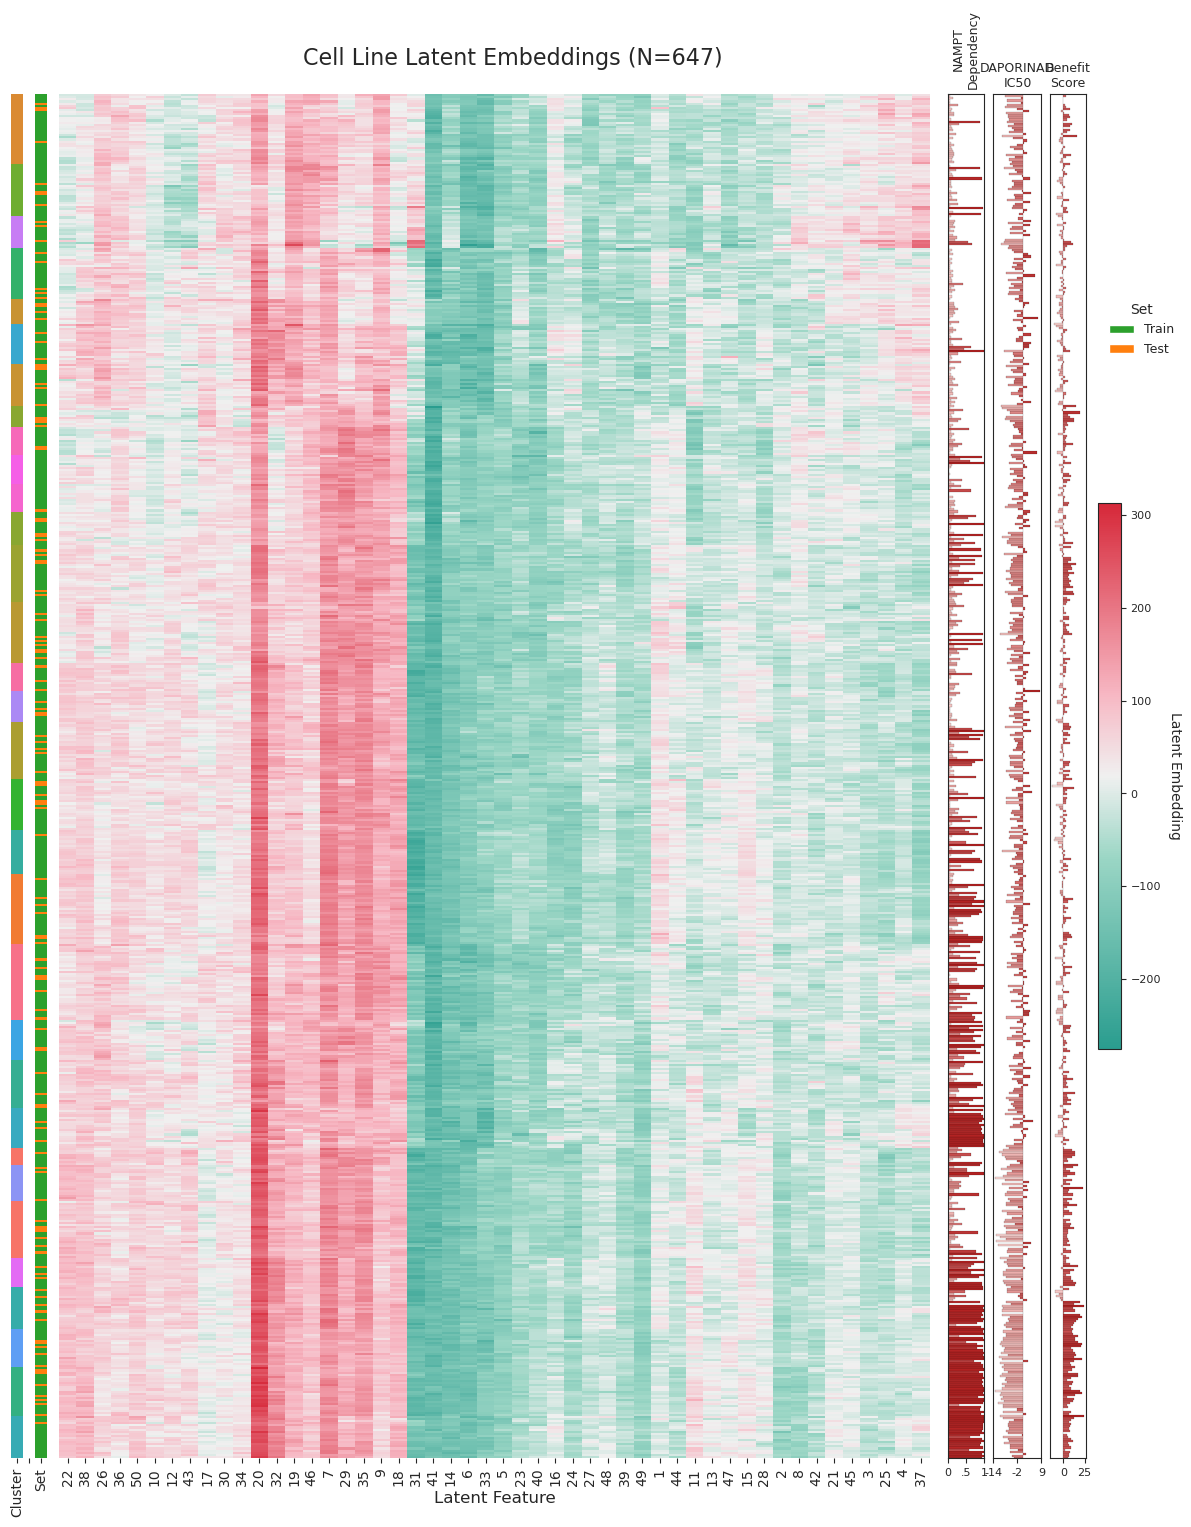

In [ ]:
# ==========================================
# 6. Visualization
# ==========================================
# Define Colormaps
deep_green = '#2a9d8f'; soft_green = '#9bd6c5'; neutral = '#f0f0f0'; soft_pink = '#f7b7c3'; deep_pink = '#d62839'
green_pink_cmap = LinearSegmentedColormap.from_list('green_pink_cmap', [(0.0, deep_green), (0.35, soft_green), (0.5, neutral), (0.65, soft_pink), (1.0, deep_pink)], N=256)
muted_reds = LinearSegmentedColormap.from_list("muted_reds", ["mistyrose", "indianred", "firebrick"])

print("Generating the final heatmap...")
cg = sns.clustermap(
    Z_plot_df,
    row_linkage=row_link,
    col_linkage=col_link,
    row_colors=row_colors_df,
    cmap=green_pink_cmap,
    figsize=(12, 15),
    cbar_pos=None,
    dendrogram_ratio=(0.04, 0.03),
    linewidths=0
)

# Rasterize heatmap
for artist in cg.ax_heatmap.collections:
    artist.set_rasterized(True)

# --- Layout Adjustments ---
fig = cg.fig
heatmap_ax = cg.ax_heatmap
heatmap_pos = heatmap_ax.get_position()

# Position Row Colors
cg.ax_row_colors.set_position([heatmap_pos.x0 - 0.04, heatmap_pos.y0, 0.03, heatmap_pos.height])
if cg.ax_col_colors is not None:
    cg.ax_col_colors.set_visible(False)

# Position Dendrogram
dendro_ax = cg.ax_row_dendrogram
dendro_ax.set_position([0.02, heatmap_pos.y0, 0.05, heatmap_pos.height])
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

# Clean Heatmap Axis
row_order = cg.dendrogram_row.reordered_ind
ordered_labels = Z_plot_df.index[row_order]
heatmap_ax.set_yticks([])
heatmap_ax.tick_params(axis='y', labelright=False, labelleft=False, length=0)
heatmap_ax.set_xlabel("Latent Feature", fontsize=12)
heatmap_ax.set_ylabel("")

# --- Side Bar Plots ---

# 1. Dependency
egfr_ax = fig.add_axes([heatmap_pos.x1 + 0.015, heatmap_pos.y0, 0.03, heatmap_pos.height])
dep_vals = Z_combined_df.loc[ordered_labels, "actual_dep_NAMPT"]
# Dynamic normalization based on data range (usually 0 to 1 for dep)
dep_norm = Normalize(vmin=0, vmax=1) 
dep_colors = muted_reds(dep_norm(dep_vals))

egfr_ax.barh(np.arange(len(dep_vals)), dep_vals, height=1.0, color=dep_colors, edgecolor='black', linewidth=0.1)
egfr_ax.set_xlim(0, 1)
egfr_ax.set_ylim(0, len(ordered_labels))
egfr_ax.set_xticks([0, 0.5, 1])
egfr_ax.set_xticklabels(["0", ".5", "1"], fontsize=8)
egfr_ax.set_yticks([])
egfr_ax.set_title(f"{model.target}\nDependency", fontsize=9, rotation=90)
for bar in egfr_ax.patches:
    bar.set_rasterized(True)

# 2. IC50
ic50_ax = fig.add_axes([heatmap_pos.x1 + 0.053, heatmap_pos.y0, 0.04, heatmap_pos.height])
ic50_vals = Z_combined_df.loc[ordered_labels, "actual_IC50"]

# Calculate dynamic limits for IC50 to prevent empty plots if range differs from previous project
ic50_min, ic50_max = np.floor(ic50_vals.min()), np.ceil(ic50_vals.max())
ic50_norm = Normalize(vmin=ic50_min, vmax=ic50_max)
ic50_colors = muted_reds(ic50_norm(ic50_vals))

ic50_ax.barh(np.arange(len(ic50_vals)), ic50_vals, height=1.0, color=ic50_colors, edgecolor='black', linewidth=0.1)
ic50_ax.set_xlim(ic50_min, ic50_max)
ic50_ax.set_ylim(0, len(ordered_labels))
# Set simplified ticks
ic50_ax.set_xticks([ic50_min, (ic50_min+ic50_max)/2, ic50_max])
ic50_ax.set_xticklabels([f"{int(ic50_min)}", f"{int((ic50_min+ic50_max)/2)}", f"{int(ic50_max)}"], fontsize=8)
ic50_ax.set_yticks([])
ic50_ax.set_title(f"{model.drug}\nIC50", fontsize=9, loc='center', pad=5)
for bar in ic50_ax.patches:
    bar.set_rasterized(True)

# 3. Benefit Score
benefit_ax = fig.add_axes([heatmap_pos.x1 + 0.1, heatmap_pos.y0, 0.03, heatmap_pos.height])
benefit_vals = Z_combined_df.loc[ordered_labels, "Benefit_Score"]
benefit_norm = Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())
benefit_colors = muted_reds(benefit_norm(benefit_vals))

benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_colors, edgecolor='black', linewidth=0.1)
benefit_ax.set_ylim(0, len(ordered_labels))
benefit_ax.set_yticks([])
benefit_ax.tick_params(axis='x', labelsize=8)
benefit_ax.set_title("Benefit\nScore", fontsize=9, loc='center', pad=5)
for bar in benefit_ax.patches:
    bar.set_rasterized(True)

# --- Legends & Colorbars ---

# Heatmap Colorbar
cbar_ax = fig.add_axes([
    heatmap_pos.x1 + 0.14,
    heatmap_pos.y0 + heatmap_pos.height * 0.3,
    0.019,
    heatmap_pos.height * 0.4
])
sm = plt.cm.ScalarMappable(cmap=green_pink_cmap, norm=Normalize(vmin=Z_plot_df.values.min(), vmax=Z_plot_df.values.max()))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Latent Embedding', fontsize=10, rotation=270, labelpad=15)

# Set Legend
legend_ax = fig.add_axes([heatmap_pos.x1 + 0.14, heatmap_pos.y0 + heatmap_pos.height*0.80, 0.015, heatmap_pos.height*0.25])
handles = [Patch(facecolor=color, label=label) for label, color in set_lut.items()]
legend_ax.legend(handles=handles, title='Set', frameon=False, loc='lower left', fontsize=9)
legend_ax.axis('off')

# Save/Show
fig.suptitle(f"Cell Line Latent Embeddings (N={len(Z_combined_df)})", y=0.99, fontsize=16)

#save_path_fig = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/Heatmap_combined_NEW.pdf"
# Ensure directory exists
#os.makedirs(os.path.dirname(save_path_fig), exist_ok=True)
#plt.savefig(save_path_fig, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
Z_combined_df

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,actual_dep_EGFR,actual_IC50,pred_dep_EGFR,pred_IC50,Set,Benefit_Score
Cell_line,,,,,,,,,,,,,,,,,,,,,
CAPAN1,34.862355,12.731788,-28.356572,-6.999353,-81.356439,-102.847317,153.793812,59.630807,145.065612,-14.992981,...,-2.194876,-16.975515,-31.969900,8.167136,0.916483,-2.05510,-0.505783,-4.303600,Train,3.797817
COV434,-12.609917,-45.059889,-3.034140,51.632878,-58.030502,-164.070063,118.829840,10.067337,92.575252,48.755525,...,-56.998516,-5.406751,-23.641821,58.576286,0.176999,-7.38299,-0.778866,-11.031161,Train,10.252296
HS578T,-17.393503,-86.054662,-33.715694,-2.164938,-81.725791,-144.931777,189.078658,-83.342151,66.319336,59.318816,...,34.762627,11.069185,-91.597040,111.472112,0.414526,-5.76390,-1.860274,-2.944834,Train,1.084560
SKES1,-18.483221,-38.063329,37.205716,44.202261,-66.163670,-126.481617,91.188332,9.300204,122.870673,40.834532,...,-11.503233,-20.918483,-87.086903,57.512030,0.351886,3.10962,-1.219776,-4.367228,Train,3.147452
NCIH1299,27.894133,-6.481438,-32.011208,4.711831,-62.399242,-144.686709,148.477052,-27.312003,99.382873,73.130216,...,-33.984195,10.058392,-70.545542,57.985269,0.075708,-3.39070,-1.018305,-5.325919,Train,4.307614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OVCAR8,3.595970,-54.812587,-24.697529,21.904125,-79.851303,-121.905175,203.065799,-39.786481,87.535001,68.861229,...,20.414580,21.854374,-94.437501,108.182674,0.568278,-8.78544,-1.125777,-10.219641,Test,9.093863
SNU216,51.280914,-3.998292,-25.343474,-16.497143,-78.630768,-112.593816,176.674391,0.357069,133.985879,47.754141,...,14.046570,-28.051154,-43.330004,53.100989,0.032427,-6.46168,-1.427823,8.640258,Test,-10.068081
LS1034,18.122192,16.645870,4.118154,-32.124284,-94.840986,-60.382593,166.023868,26.805302,94.561300,-26.151402,...,-23.181492,2.690261,-37.334325,25.937615,0.036855,-3.28051,-0.001040,-4.051283,Test,4.050243


   Latent Dimension     Variance  Variance Ratio (%)
1                 1  1154.718674            1.696387
2                 2   966.613793            1.420044
3                 3  1122.659752            1.649289
4                 4  1381.227077            2.029148
5                 5   540.096215            0.793451


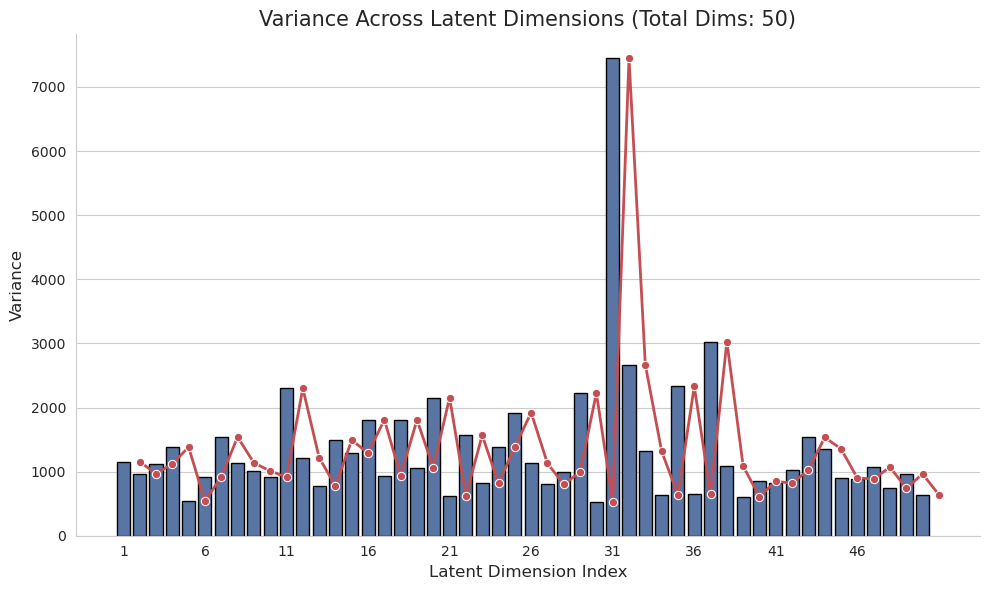

In [ ]:
# ==========================================
# 3. Calculate Variance per Dimension
# ==========================================
# Calculate variance for each column (latent factor)
variances = np.var(Z_combined_df.iloc[:, :50], axis=0)

# Calculate percentage of total variance (optional, but useful)
total_variance = np.sum(variances)
variance_ratio = variances / total_variance * 100

# Create a DataFrame for plotting
df_var = pd.DataFrame({
    "Latent Dimension": np.arange(1, len(variances) + 1),
    "Variance": variances,
    "Variance Ratio (%)": variance_ratio
})

# Sort by Variance (descending) usually best for scree plots, 
# but we keep index order if factors are not pre-sorted by importance.
# If your model (DAPORINAD) doesn't enforce order, we plot as is.
# df_var = df_var.sort_values(by="Variance", ascending=False) 

print(df_var.head())

# ==========================================
# 4. Plotting (Scree Plot)
# ==========================================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Bar plot for absolute variance
ax = sns.barplot(
    data=df_var,
    x="Latent Dimension",
    y="Variance",
    color="#4c72b0",
    edgecolor="black"
)

# Add line plot overlay
sns.lineplot(
    data=df_var,
    x=df_var.index, # aligns with barplot indices
    y="Variance",
    color="#c44e52",
    marker="o",
    linewidth=2,
    ax=ax
)

# Annotations
plt.title(f"Variance Across Latent Dimensions (Total Dims: {len(variances)})", fontsize=15)
plt.xlabel("Latent Dimension Index", fontsize=12)
plt.ylabel("Variance", fontsize=12)

# Improve x-axis ticks (show every 5th tick if too many dimensions)
if len(variances) > 20:
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  # every 5th label
            label.set_visible(True)
        else:
            label.set_visible(False)

sns.despine()
plt.tight_layout()

# Save
#save_path = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Figures_latent/Fig_Variance_Scree.pdf"
#plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
plot_df

,1,2,3,4,5,6,7,8,9,10,...,48,49,50,actual_dep_EGFR,actual_IC50,pred_dep_EGFR,pred_IC50,Set,Benefit_Score,Cluster
Cell_line,,,,,,,,,,,,,,,,,,,,,
CAPAN1,34.862355,12.731788,-28.356572,-6.999353,-81.356439,-102.847317,153.793812,59.630807,145.065612,-14.992981,...,-16.975515,-31.969900,8.167136,0.916483,-2.05510,-0.505783,-4.303600,Train,3.797817,26
COV434,-12.609917,-45.059889,-3.034140,51.632878,-58.030502,-164.070063,118.829840,10.067337,92.575252,48.755525,...,-5.406751,-23.641821,58.576286,0.176999,-7.38299,-0.778866,-11.031161,Train,10.252296,19
HS578T,-17.393503,-86.054662,-33.715694,-2.164938,-81.725791,-144.931777,189.078658,-83.342151,66.319336,59.318816,...,11.069185,-91.597040,111.472112,0.414526,-5.76390,-1.860274,-2.944834,Train,1.084560,25
SKES1,-18.483221,-38.063329,37.205716,44.202261,-66.163670,-126.481617,91.188332,9.300204,122.870673,40.834532,...,-20.918483,-87.086903,57.512030,0.351886,3.10962,-1.219776,-4.367228,Train,3.147452,5
NCIH1299,27.894133,-6.481438,-32.011208,4.711831,-62.399242,-144.686709,148.477052,-27.312003,99.382873,73.130216,...,10.058392,-70.545542,57.985269,0.075708,-3.39070,-1.018305,-5.325919,Train,4.307614,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OVCAR8,3.595970,-54.812587,-24.697529,21.904125,-79.851303,-121.905175,203.065799,-39.786481,87.535001,68.861229,...,21.854374,-94.437501,108.182674,0.568278,-8.78544,-1.125777,-10.219641,Test,9.093863,16
SNU216,51.280914,-3.998292,-25.343474,-16.497143,-78.630768,-112.593816,176.674391,0.357069,133.985879,47.754141,...,-28.051154,-43.330004,53.100989,0.032427,-6.46168,-1.427823,8.640258,Test,-10.068081,23
LS1034,18.122192,16.645870,4.118154,-32.124284,-94.840986,-60.382593,166.023868,26.805302,94.561300,-26.151402,...,2.690261,-37.334325,25.937615,0.036855,-3.28051,-0.001040,-4.051283,Test,4.050243,27


Cell lines assigned to 28 clusters.

--- Analyzing Metric Distributions Across Clusters ---
Global Median IC50: -4.29
Global Median Benefit Score: 1.83
Global Median Dependency: 0.23


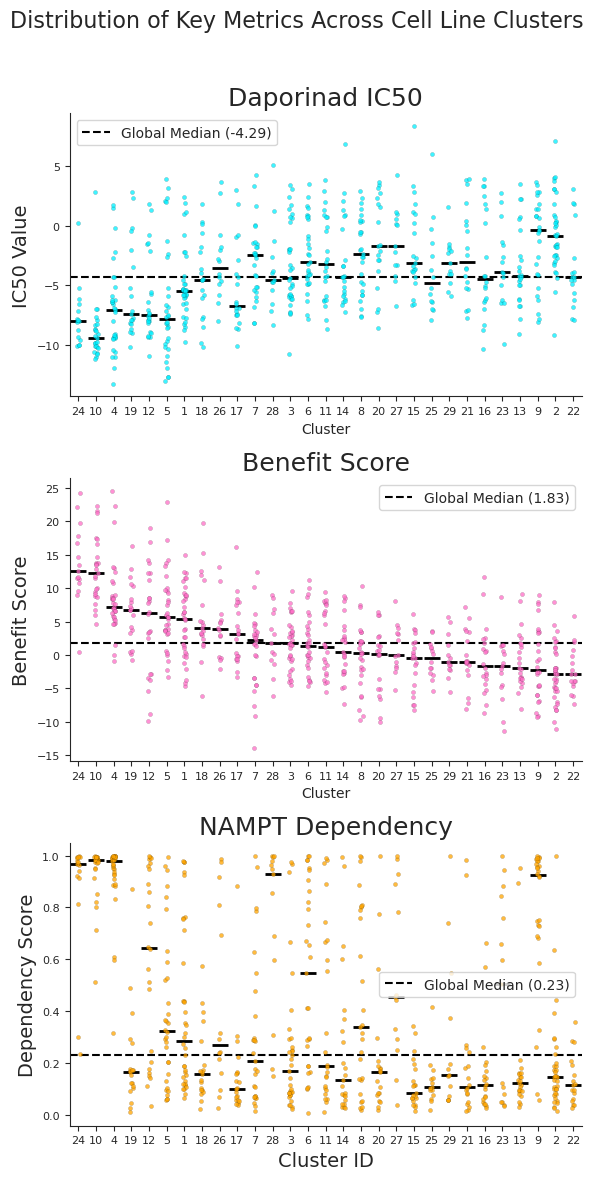

In [ ]:
from scipy.stats import f_oneway


Z_combined_df['Cluster'] = pd.Series(cluster_result["labels"], index=Z_plot_df.index)
print(f"Cell lines assigned to {len(Z_combined_df['Cluster'].unique()) - 1} clusters.")

    
# === 4. Prepare Data and Calculate Global Medians ===
print("\n--- Analyzing Metric Distributions Across Clusters ---")
plot_df = Z_combined_df[Z_combined_df['Cluster'] != 0].copy()
ic50_order = plot_df.groupby('Cluster')['Benefit_Score'].median().sort_values(ascending=False).index

# Calculate the median value for each metric across ALL cell lines
median_ic50 = plot_df['actual_IC50'].median()
median_benefit = plot_df['Benefit_Score'].median()
median_dependency = plot_df['actual_dep_NAMPT'].median()

print(f"Global Median IC50: {median_ic50:.2f}")
print(f"Global Median Benefit Score: {median_benefit:.2f}")
print(f"Global Median Dependency: {median_dependency:.2f}")

# Set style
sns.set_style("ticks")

# Use a brighter version of Set2 palette
# === Neon Color Palette ===
# Use a custom neon-inspired color palette
# Use a custom neon-inspired color palette
neon_palette = ["#00F0FF", "#FFA500", "#FF6EC7"]  # Neon sky blue, neon orange, neon pink

color_ic50 = neon_palette[0]  # Neon Sky Blue
color_dep = neon_palette[1]  # Neon Orange
color_bs = neon_palette[2]   # Neon Pink


# Create vertical subplots with narrower width
fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=False)
fig.suptitle('Distribution of Key Metrics Across Cell Line Clusters', fontsize=16, y=0.98)

# --- Plot 1: IC50 ---
sns.stripplot(
    data=plot_df, x='Cluster', y='actual_IC50', order=ic50_order,
    ax=axes[0], jitter=True, alpha=0.75, color=color_ic50, size=3,
    edgecolor='black', linewidth=0.1
)
sns.pointplot(data=plot_df, x='Cluster', y='actual_IC50', order=ic50_order,
              ax=axes[0], estimator=np.median, color="black",
              markers="_", linestyles="", errorbar=None,  markersize=12)
axes[0].axhline(median_ic50, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_ic50:.2f})')
axes[0].set_title('Daporinad IC50', fontsize=18)
axes[0].set_ylabel('IC50 Value', fontsize=14)
axes[0].legend()
sns.despine(ax=axes[0])
axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)
plt.setp(axes[0].get_xticklabels(), rotation=0, ha='center')


# --- Plot 2: Benefit Score ---
sns.stripplot(
    data=plot_df, x='Cluster', y='Benefit_Score', order=ic50_order,
    ax=axes[1], jitter=True, alpha=0.75, color=color_bs, size=3,
    edgecolor='black', linewidth=0.1
)
sns.pointplot(data=plot_df, x='Cluster', y='Benefit_Score', order=ic50_order,
              ax=axes[1], estimator=np.median, color="black",
              markers="_", linestyles="", errorbar=None, markersize=12)
axes[1].axhline(median_benefit, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_benefit:.2f})')
axes[1].set_title('Benefit Score', fontsize=18)
axes[1].set_ylabel('Benefit Score', fontsize=14)
axes[1].legend()
sns.despine(ax=axes[1])
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)
plt.setp(axes[1].get_xticklabels(), rotation=0, ha='center')

# --- Plot 3: EGFR Dependency ---
sns.stripplot(
    data=plot_df, x='Cluster', y='actual_dep_NAMPT', order=ic50_order,
    ax=axes[2], jitter=True, alpha=0.75, color=color_dep, size=3,
    edgecolor='black', linewidth=0.1
)
sns.pointplot(data=plot_df, x='Cluster', y='actual_dep_NAMPT', order=ic50_order,
              ax=axes[2], estimator=np.median, color="black",
              markers="_", linestyles="", errorbar=None, markersize=12)
axes[2].axhline(median_dependency, color='black', linestyle='--', linewidth=1.5,
                label=f'Global Median ({median_dependency:.2f})')
axes[2].set_title('NAMPT Dependency', fontsize=18)
axes[2].set_ylabel('Dependency Score', fontsize=14)
axes[2].set_xlabel('Cluster ID', fontsize=14)
axes[2].legend()
sns.despine(ax=axes[2])
axes[2].tick_params(axis='x', labelsize=8)
axes[2].tick_params(axis='y', labelsize=8)
plt.setp(axes[2].get_xticklabels(), rotation=0, ha='center')


# Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Rasterize scatter points for each plot
for ax in axes:
    for coll in ax.collections:
        coll.set_rasterized(True)

# === Save the figure ===
fig.savefig(
    "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/cluster_stripplot_vertical.pdf",
    dpi=600, bbox_inches='tight'
)

plt.show()


In [ ]:
Z_combined_df.to_csv('Daporinad_NAMPT_fullres_optuna.csv', index = True)

In [ ]:
cell_lines = Z_combined_df.loc[
    Z_combined_df["Cluster"].isin([24, 10, 4])
].index.tolist()


In [ ]:
len(cell_lines)

73

In [ ]:
with open("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Data/Daporinad_Fig6_cluster_cell_lines.txt", "w") as f:
    f.write("\n".join(cell_lines))